In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from heapq import heappop, heappush
from random import randint
from datetime import datetime
%matplotlib inline

from src.grid import intersect_cells, Map, intersect_points
from src.theta import Node, theta, make_path
from src.lazy_theta import lazy_theta
from src.theta_ap import theta_ap
from src.utils import *
from src.search_tree import *

In [2]:
def draw(grid_map, start = None, goal = None, path = None,
         nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 50
    r = 0.25 * k
    rr = 0.05 * k
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            pass
            draw.ellipse((j * k - rr, i * k - rr, j * k + rr, i * k + rr), fill=(50, 50, 50))
    
    # obstacles
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    # opened
    if nodes_opened is not None:
        for node in nodes_opened:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    # expanded
    if nodes_expanded is not None:
        for node in nodes_expanded:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    # reexpanded
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
            pass
#                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    # path
    if path is not None:
        for step in path:
            draw.line(((step.j * k, step.i * k), (step.parent.j * k, step.parent.i * k)), fill=(219, 152, 52))
            draw.ellipse((step.j * k - r, step.i * k - r, step.j * k + r, step.i * k + r), fill=(52, 152, 219))
                
    # start
    draw.ellipse((start.j * k - r, start.i * k - r, start.j * k + r, start.i * k + r), fill=(40, 180, 99))
    
    # goal
    draw.ellipse((goal.j * k - r, goal.i * k - r, goal.j * k + r, goal.i * k + r), fill=(231, 76, 60))


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

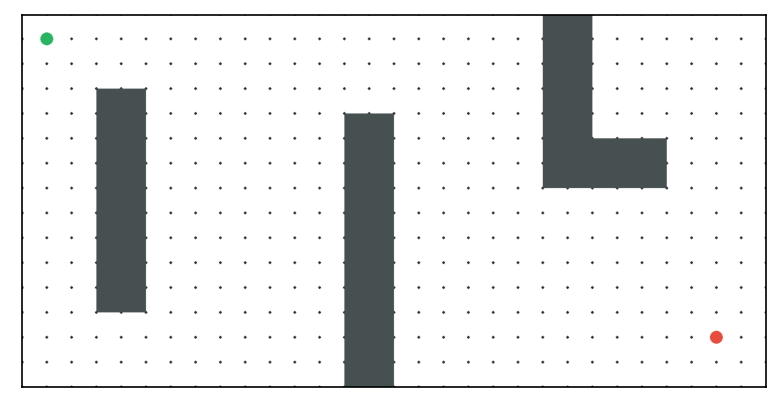

In [3]:
height = 15
width = 30
map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

In [4]:
def simple_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (7, 1), (9, 2), (3, 5), (3, 5)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (4, 26), (3, 17), (9, 2), (3, 5)]

    if (task is None) or not (0 <= task < len(starts)):
        task = randint(0, len(starts) - 1)
        
    print("task number: ", task)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_steps = result[2].expansions
        nodes_created = result[2].max_tree_size
        if result[0]:
            path = make_path(result[1])
            print("Path found! Length: " + str(result[2].way_length) + \
                ". Memory_usage: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps))
            path_cells = [(node.i, node.j) for node in path[0]]
            print(path_cells)
            draw(task_map, start, goal, path[0], *result[3:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


task number:  6
Path found! Length: 26.015339721864635. Memory_usage: 289. Number of steps: 199
[(5, 6), (4, 13), (4, 15), (7, 21), (7, 26), (4, 26), (2, 25)]


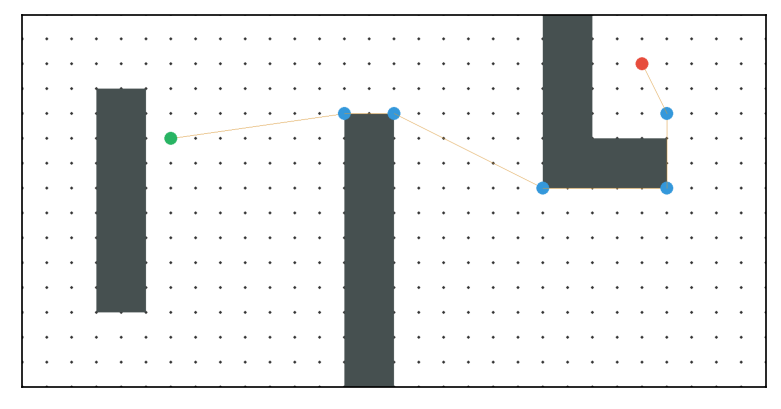

CPU times: user 205 ms, sys: 131 ms, total: 336 ms
Wall time: 199 ms


In [5]:
%time res = simple_test(theta, 6, euclidian_distance, SearchTreePQS, k = 8)

task number:  6
Path found! Length: 26.015339721864635. Memory_usage: 300. Number of steps: 199
[(5, 6), (4, 13), (4, 15), (7, 21), (7, 26), (4, 26), (2, 25)]


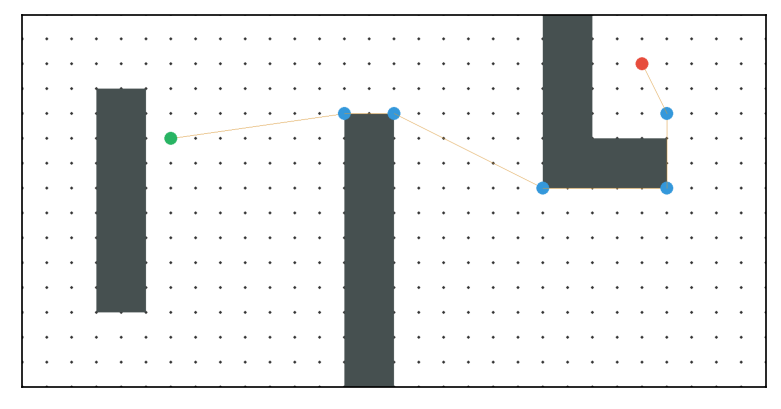

CPU times: user 272 ms, sys: 180 ms, total: 452 ms
Wall time: 217 ms


In [6]:
%time res = simple_test(lazy_theta, 6, euclidian_distance, SearchTreePQS, k = 8)

task number:  6
up  vector by cell  (4, 13) to (-1, 7)
up  vector by cell  (4, 13) to (0, 1)
up  vector by cell  (4, 14) to (0, 2)
up  vector by cell  (3, 21) to (-1, 8)
up  vector by cell  (2, 21) to (-2, 8)
low vector by cell  (5, 13) to (1, 7)
up  vector by cell  (1, 21) to (-3, 8)
low vector by cell  (4, 21) to (1, 6)
low vector by cell  (6, 13) to (2, 7)
up  vector by cell  (4, 14) to (1, 0)
low vector by cell  (7, 13) to (3, 7)
low vector by cell  (5, 21) to (2, 6)
low vector by cell  (4, 4) to (-1, -1)
up  vector by cell  (5, 4) to (1, -1)
up  vector by cell  (5, 14) to (2, 0)
low vector by cell  (8, 13) to (1, 1)
low vector by cell  (6, 21) to (3, 6)
low vector by cell  (3, 4) to (-2, -1)
low vector by cell  (6, 21) to (0, 1)
up  vector by cell  (6, 4) to (2, -1)
low vector by cell  (9, 13) to (5, 7)
low vector by cell  (6, 22) to (0, 2)
up  vector by cell  (6, 14) to (3, 0)
low vector by cell  (6, 23) to (0, 3)
up  vector by cell  (7, 4) to (3, -1)
low vector by cell  (10, 13)

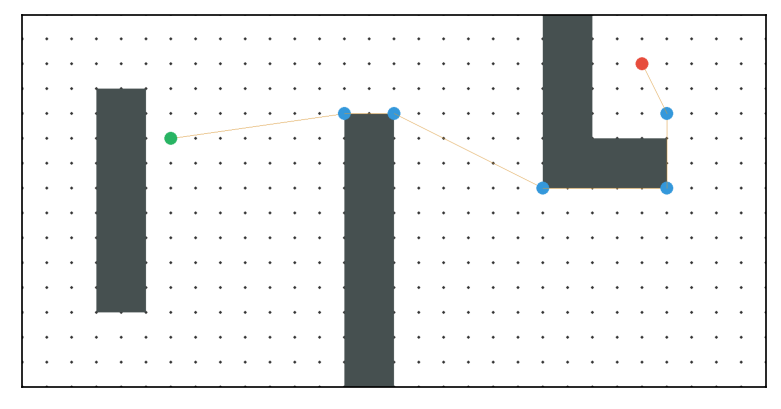

CPU times: user 232 ms, sys: 140 ms, total: 372 ms
Wall time: 213 ms


In [7]:
%time res = simple_test(theta_ap, 6, euclidian_distance, SearchTreePQS)

task number:  14
up  vector by cell  (3, 4) to (2, 4)
low vector by cell  (5, 13) to (5, 12)
low vector by cell  (6, 13) to (6, 12)
up  vector by cell  (3, 3) to (2, 3)
low vector by cell  (4, 13) to (4, 12)
low vector by cell  (7, 13) to (2, 2)
up  vector by cell  (4, 13) to (0, 4)
low vector by cell  (8, 13) to (4, 4)
up  vector by cell  (3, 4) to (1, 0)
low vector by cell  (3, 3) to (3, 2)
up  vector by cell  (4, 14) to (0, 5)
Path found! Length: 31.130149957598377. Memory_usage: 210. Number of steps: 80
[(1, 1), (4, 10), (4, 15), (13, 29)]


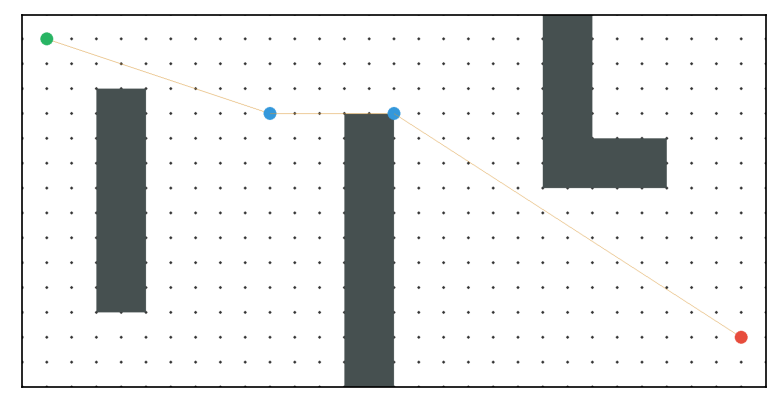

CPU times: user 218 ms, sys: 171 ms, total: 389 ms
Wall time: 196 ms


In [8]:
%time res = simple_test(theta_ap, None, euclidian_distance, SearchTreePQS_SDD)

task number:  6
up  vector by cell  (4, 13) to (-1, 7)
up  vector by cell  (4, 13) to (0, 1)
up  vector by cell  (4, 14) to (0, 2)
low vector by cell  (5, 13) to (1, 7)
up  vector by cell  (3, 21) to (-1, 8)
up  vector by cell  (2, 21) to (-2, 8)
low vector by cell  (6, 13) to (2, 7)
up  vector by cell  (1, 21) to (-2, 7)
up  vector by cell  (4, 14) to (1, 0)
low vector by cell  (4, 4) to (-1, -1)
low vector by cell  (4, 21) to (1, 6)
up  vector by cell  (5, 4) to (1, -1)
low vector by cell  (7, 13) to (1, 1)
low vector by cell  (3, 4) to (-2, -1)
low vector by cell  (5, 21) to (2, 6)
low vector by cell  (8, 13) to (4, 7)
up  vector by cell  (5, 14) to (2, 0)
up  vector by cell  (6, 4) to (2, -1)
low vector by cell  (6, 21) to (3, 6)
low vector by cell  (9, 13) to (5, 7)
up  vector by cell  (7, 4) to (3, -1)
up  vector by cell  (6, 14) to (3, 0)
low vector by cell  (6, 21) to (0, 1)
low vector by cell  (3, 4) to (0, -1)
low vector by cell  (10, 13) to (6, 7)
low vector by cell  (6, 22)

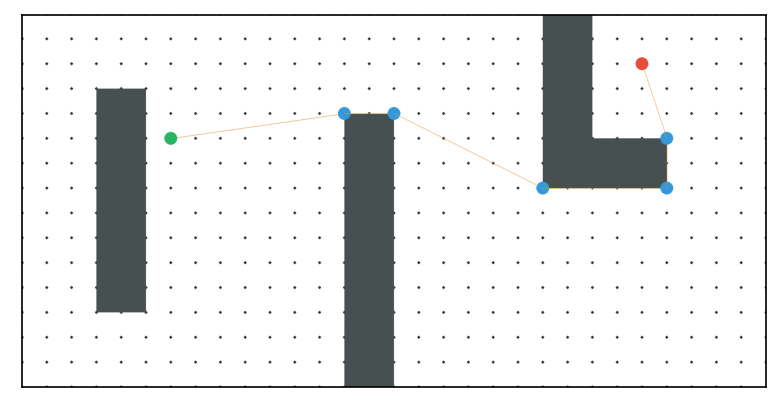

CPU times: user 272 ms, sys: 251 ms, total: 523 ms
Wall time: 259 ms


In [9]:
%time res = simple_test(theta_ap, 6, weighted_heuristic, SearchTreePQS)

In [10]:
def contr_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 4
    width = 4
    map_str = '''
@@@.
...@
.@..
.@.@
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(4, 3), (4, 3)]
    goals = [(2, 0), (1, 3)]

    if (task is None) or not (0 <= task < len(starts)):
        task = randint(0, len(starts) - 1)
        
    print("task number: ", task)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_steps = result[2].expansions
        nodes_created = result[2].max_tree_size
        if result[0]:
            path = make_path(result[1])
            print("Path found! Length: " + str(result[2].way_length) + \
                ". Memory_usage: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps))
            path_cells = [(node.i, node.j) for node in path[0]]
            print(path_cells)
            draw(task_map, start, goal, path[0], *result[3:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


task number:  0
low vector by cell  (3, 1) to (-1, -1)
up  vector by cell  (3, 3) to (-1, 0)
low vector by cell  (2, 1) to (-2, -1)
low vector by cell  (2, 1) to (0, -1)
Path found! Length: 4.23606797749979. Memory_usage: 14. Number of steps: 5
[(4, 3), (2, 2), (2, 0)]


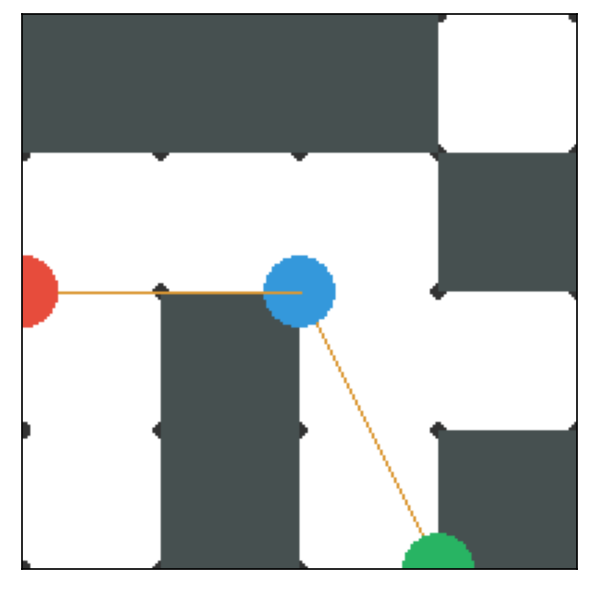

CPU times: user 110 ms, sys: 53.1 ms, total: 163 ms
Wall time: 93.3 ms


In [11]:
%time res = contr_test(theta_ap, 0, euclidian_distance, SearchTreePQS)

In [12]:
def special_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 5
    width = 7
    map_str = '''
.......
.......
.@.....
.@.....
.@.....
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(0, 7), (0, 7)]
    goals = [(2, 1), (4, 0)]

    if (task is None) or not (0 <= task < len(starts)):
        task = randint(0, len(starts) - 1)
        
    print("task number: ", task)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_steps = result[2].expansions
        nodes_created = result[2].max_tree_size
        if result[0]:
            path = make_path(result[1])
            print("Path found! Length: " + str(result[2].way_length) + \
                ". Memory_usage: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps))
            path_cells = [(node.i, node.j) for node in path[0]]
            print(path_cells)
            draw(task_map, start, goal, path[0], *result[3:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


task number:  0
Path found! Length: 6.324555320336759. Memory_usage: 21. Number of steps: 6
[(0, 7), (2, 1)]


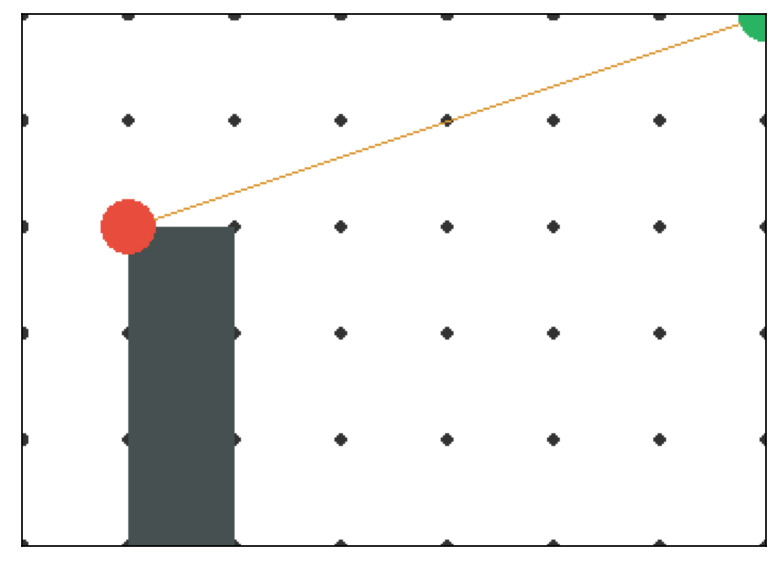

CPU times: user 164 ms, sys: 143 ms, total: 306 ms
Wall time: 114 ms


In [13]:
%time res = special_test(theta_ap, 0, euclidian_distance, SearchTreePQSReexp)

task number:  1
up  vector by cell  (2, 1) to (3, -5)
up  vector by cell  (3, 1) to (4, -5)
low vector by cell  (2, 1) to (2, -6)
Path found! Length: 8.56062329783655. Memory_usage: 51. Number of steps: 23
[(0, 7), (2, 1), (4, 0)]


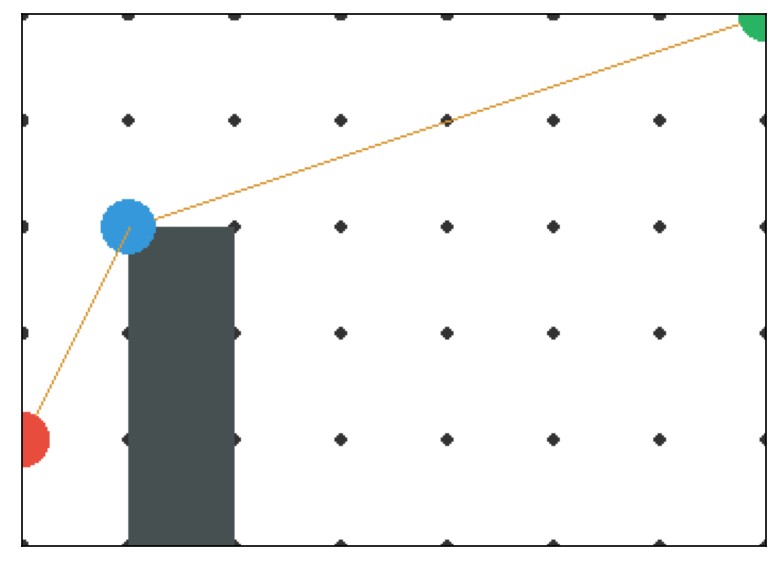

CPU times: user 218 ms, sys: 177 ms, total: 395 ms
Wall time: 147 ms


In [14]:
%time res = special_test(theta_ap, 1, euclidian_distance, SearchTreePQSReexp)